# Text classification #

In [61]:
#importing libraries
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler

In [62]:
#read data from files
Qdf=pd.read_csv("questions1.csv",encoding='latin-1')
Tdf=pd.read_csv("Tags.csv")

In [63]:
#to remove the tag sets which are not being used by questions
Tdf.Id = Tdf.Id.apply(lambda idv : idv if idv in Qdf.Id.values else None)
Tdf=Tdf.dropna()            

In [74]:
#considering only 100 most popular tags
num_classes = 100
grouped_tags = Tdf.groupby("Tag").size().reset_index(name='count')
most_common_tags = grouped_tags.nlargest(num_classes, columns="count")
Tdf.Tag = Tdf.Tag.apply(lambda tag : tag if tag in most_common_tags.Tag.values else None)
Tdf = Tdf.dropna()

#printing the top 5 and bottom 5 most popular tags
counts = Tdf.Tag.value_counts()
firstlast = counts[:5].append(counts[-5:])
firstlast.reset_index(name="count")


,index,count
0,r,645
1,regression,530
2,machine-learning,288
3,time-series,265
4,probability,233
5,covariance,27
6,binary-data,27
7,goodness-of-fit,26
8,multicollinearity,26
9,normalization,26


In [65]:
#data preprocessing
def strip_html_tags(body):
    regex = re.compile('<.*?>')
    return re.sub(regex, '', body)

Qdf['Body'] = Qdf['Body'].apply(strip_html_tags)
Qdf['Text'] = Qdf['Title'] + ' ' + Qdf['Body']

def tags_for_question(question_id):
    return Tdf[Tdf['Id'] == question_id].Tag.values

def add_tags_column(row):
    row['Tags'] = tags_for_question(row['Id'])
    return row

Qdf= Qdf.apply(add_tags_column, axis=1)
Qdf[['Id', 'Text', 'Tags']].head()


,Id,Text,Tags
0,6.0,The Two Cultures: statistics vs. machine learn...,[machine-learning]
1,21.0,Forecasting demographic census What are some o...,[forecasting]
2,22.0,Bayesian and frequentist reasoning in plain En...,[bayesian]
3,31.0,What is the meaning of p values and t values i...,"[hypothesis-testing, t-test, p-value, interpre..."
4,36.0,Examples for teaching: Correlation does not me...,[correlation]


In [66]:
#computing Term frequency
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(Qdf.Text)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [94]:
#representing the tags as binary attributes
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(Qdf.Tags)
Y = multilabel_binarizer.transform(Qdf.Tags)

#over sampling
ros = RandomOverSampler()
X_tfidf_resampled, Y_tfidf_resampled = ros.fit_sample(X_tfidf, Y)
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf_resampled, Y_tfidf_resampled, test_size=0.1, random_state=1000)


Text(0.5,1,'class distribution before resampling')

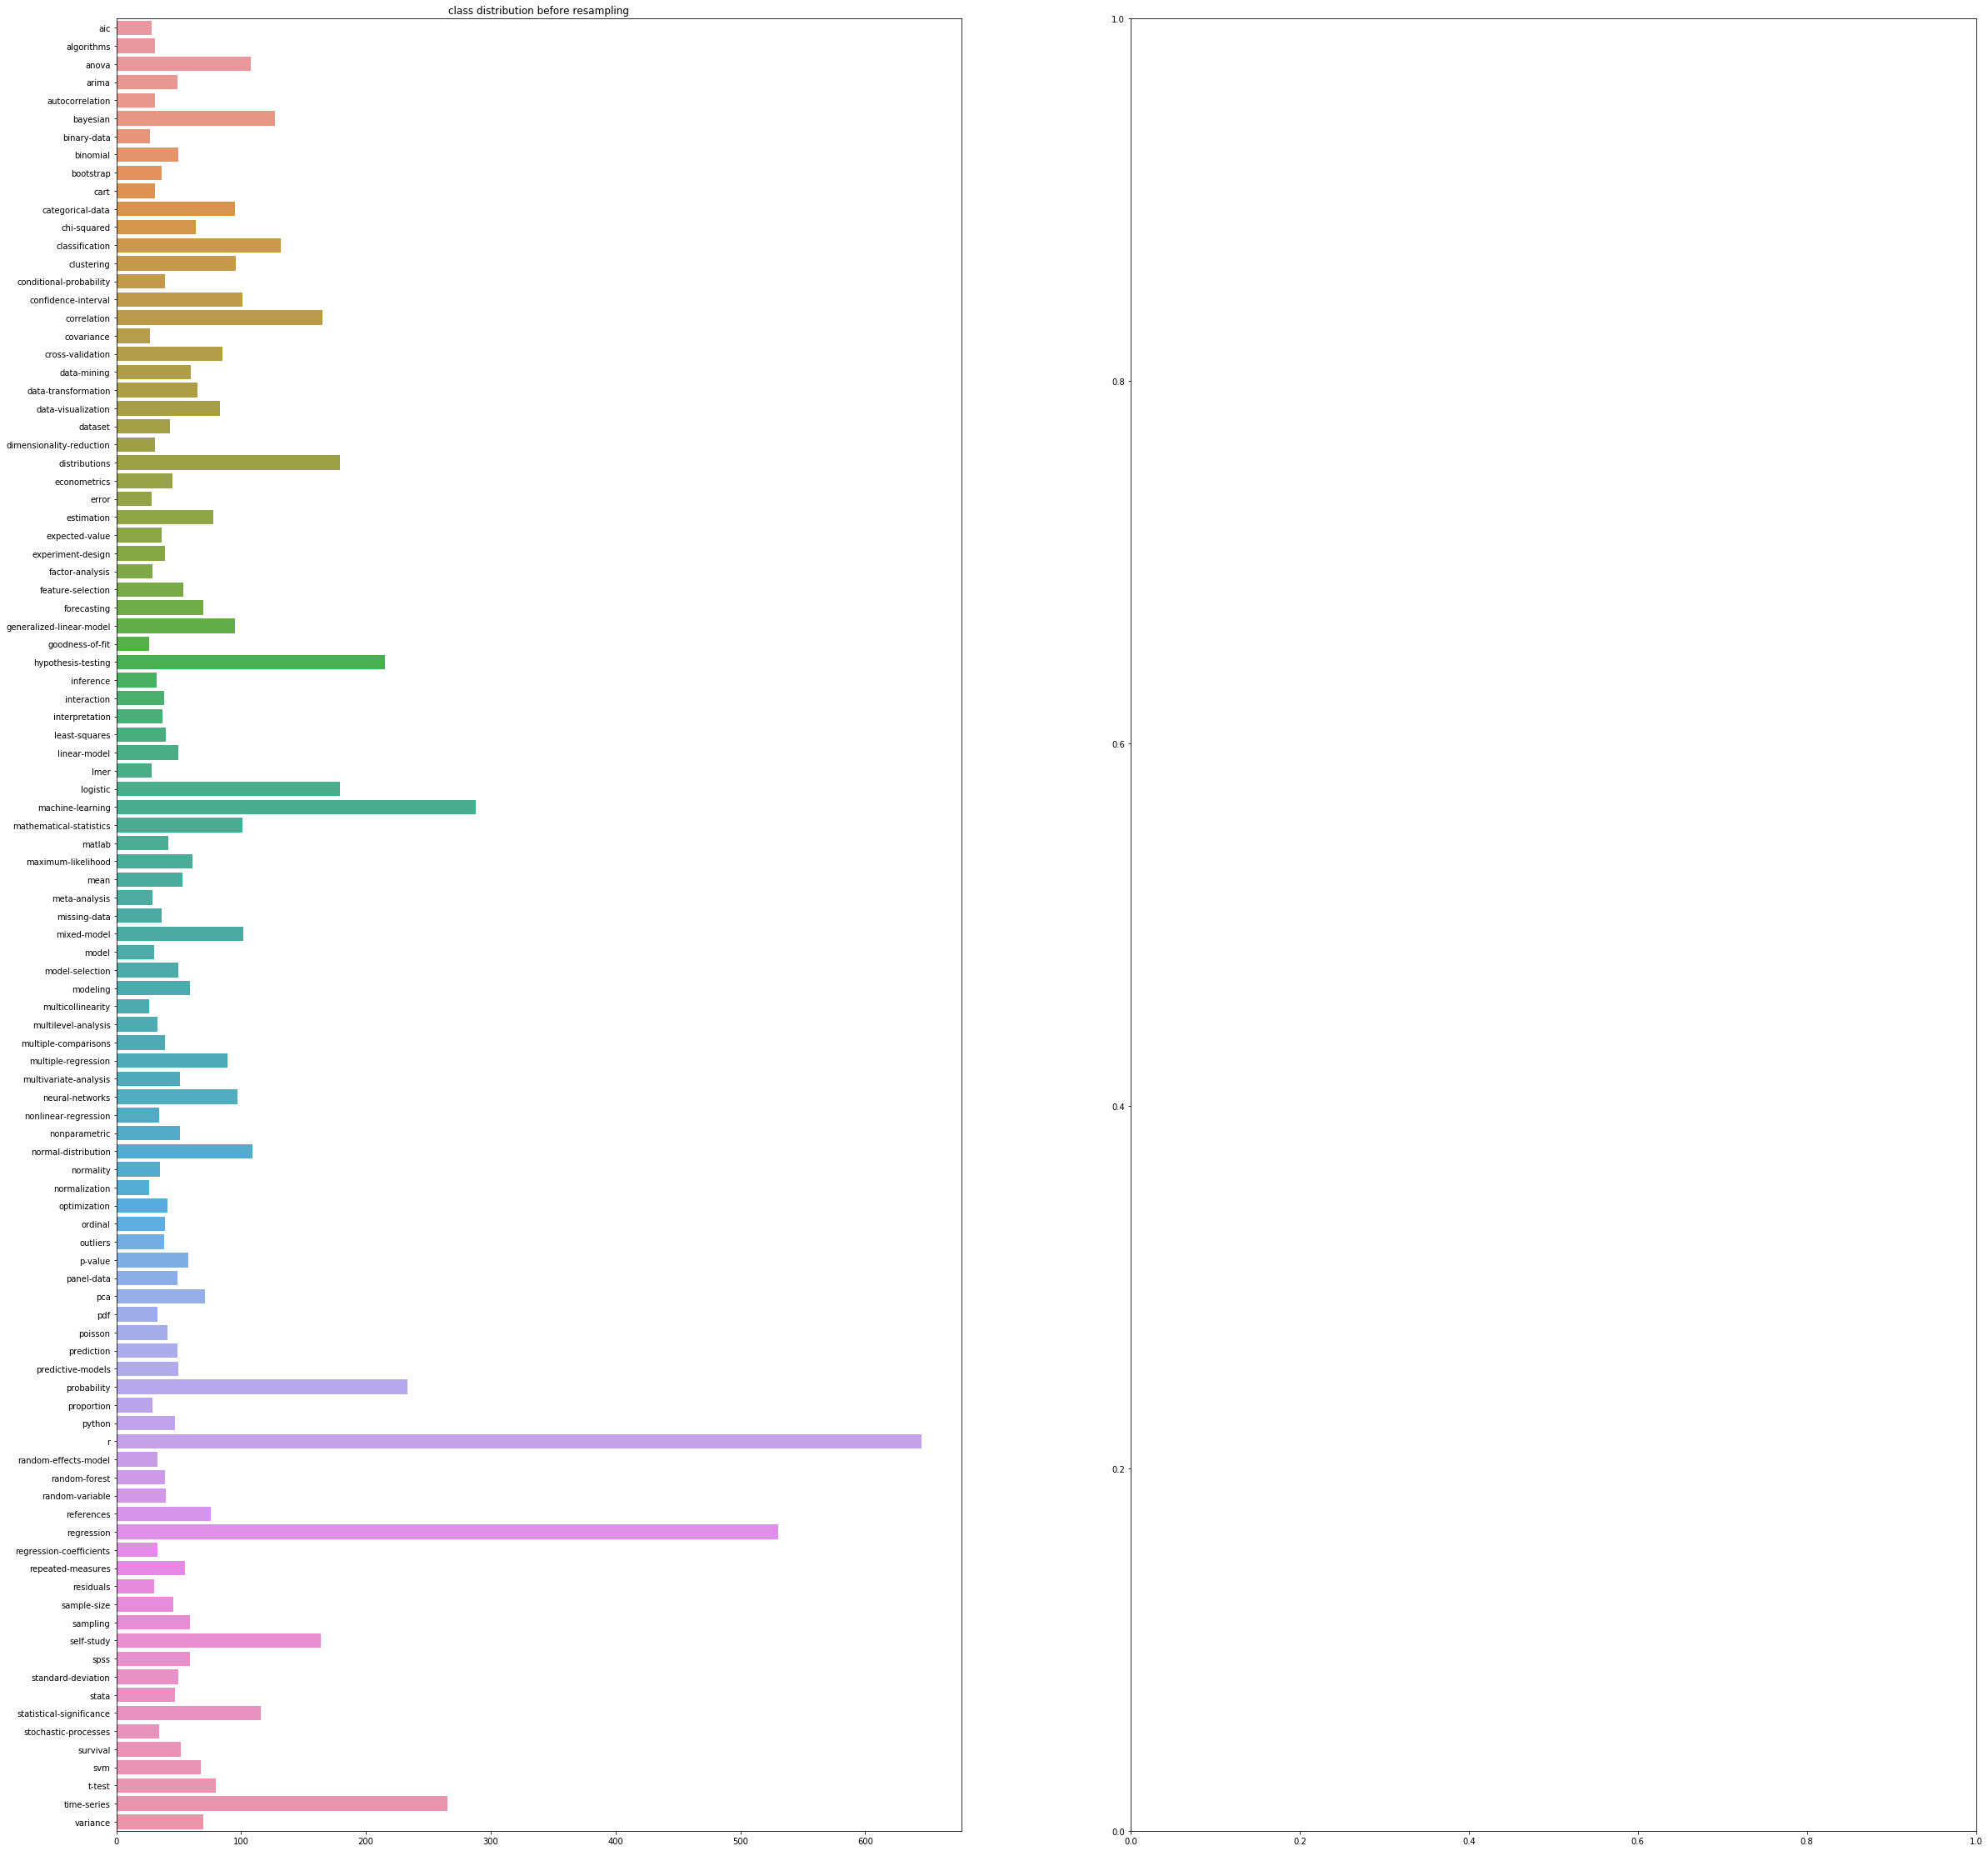

In [71]:
#plotting bargraph
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(40,40))
(ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=Y.sum(axis=0), y=multilabel_binarizer.classes_,ax=ax_test)
g2 = sns.barplot(x=y_tfidf_resampled.sum(axis=0), y=multilabel_binarizer.classes_,ax=ax_train)
g1.set_title("class distribution before resampling")
g2.set_title("Class didtribution after sampling")

In [95]:
#using one vs rest classifier with multinomialNB
classifier=MultinomialNB()
clf = OneVsRestClassifier(classifier)
clf.fit(x_train_tfidf, y_train_tfidf)
y_pred = clf.predict(x_test_tfidf)
print(np.mean(y_pred == y_test_tfidf))

C:\Users\SPANDANA\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.990766308835673
(4999, 8) (12110, 30059) (12110, 100) (12110, 100)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
['nonparametric'] []
['data-transformation'] []
['regression-coefficients'] []
['data-mining'] []
['binary-data'] ['binary-data']
['probability'] []
['correlation'] []
['normality'] []
['cart'] ['cart']
['estimation'] []
['estimation'] []
['anova'] []
['outliers'] []
['categorical-data'] []
['bayesian'] []
['binomial'] []
['multiple-regression'] []
['bootstrap'] []
['aic'] []
['binomial'] []
['least-squares'] []
['estimation'] []
['distributions'] []
['anova'] []
['repeated-measures'] []
['least-squares'] []
['mixed-m

['algorithms'] []
['dimensionality-reduction'] []
['pdf'] ['pdf']
['error'] []
['categorical-data'] []
['linear-model'] []
['generalized-linear-model'] []
['estimation'] []
['chi-squared'] []
['missing-data'] []
['clustering'] []
['svm'] []
['autocorrelation'] ['autocorrelation']
['multiple-comparisons'] []
['factor-analysis'] []
['goodness-of-fit'] []
['dimensionality-reduction'] ['dimensionality-reduction']
['lmer'] []
['classification'] []
['prediction'] []
['pca'] []
['sampling'] []
['nonparametric'] []
['cart'] ['cart']
['data-visualization'] []
['self-study'] []
['cross-validation'] []
['random-variable'] []
['standard-deviation'] []
['regression-coefficients'] []
['multilevel-analysis'] ['multilevel-analysis']
['maximum-likelihood'] []
['mathematical-statistics'] []
['machine-learning'] []
['cross-validation'] []
['pca'] []
['residuals'] []
['error'] []
['maximum-likelihood'] []
['binary-data'] []
['model'] []
['feature-selection'] []
['expected-value'] []
['statistical-signific

['survival'] []
['anova'] []
['spss'] []
['arima'] []
['forecasting'] []
['data-mining'] []
['forecasting'] []
['survival'] []
['repeated-measures'] []
['r'] []
['chi-squared'] []
['distributions'] []
['chi-squared'] []
['categorical-data'] []
['dataset'] []
['bootstrap'] []
['clustering'] []
['econometrics'] []
['repeated-measures'] []
['data-mining'] []
['normality'] []
['conditional-probability'] []
['references'] []
['data-mining'] []
['econometrics'] []
['data-mining'] []
['spss'] []
['model'] []
['distributions'] []
['sample-size'] []
['sampling'] []
['estimation'] []
['regression-coefficients'] []
['maximum-likelihood'] []
['multivariate-analysis'] []
['cart'] ['cart']
['residuals'] []
['statistical-significance'] []
['classification'] []
['distributions'] []
['multivariate-analysis'] []
['aic'] ['aic']
['data-transformation'] []
['optimization'] []
['random-variable'] []
['random-forest'] []
['poisson'] []
['proportion'] []
['panel-data'] []
['proportion'] []
['repeated-measure

['ordinal'] []
['conditional-probability'] []
['random-forest'] ['random-forest']
['interaction'] []
['spss'] []
['r'] []
['nonlinear-regression'] []
['categorical-data'] []
['error'] []
['references'] []
['estimation'] []
['multiple-regression'] []
['neural-networks'] []
['correlation'] []
['estimation'] []
['multicollinearity'] []
['survival'] []
['anova'] []
['stata'] []
['mixed-model'] []
['regression-coefficients'] []
['random-variable'] []
['missing-data'] []
['data-visualization'] []
['estimation'] []
['meta-analysis'] []
['random-forest'] ['random-forest']
['least-squares'] ['least-squares']
['multicollinearity'] []
['dataset'] []
['normalization'] []
['multivariate-analysis'] []
['ordinal'] []
['forecasting'] []
['clustering'] []
['feature-selection'] []
['generalized-linear-model'] []
['clustering'] []
['stata'] []
['regression-coefficients'] []
['classification'] []
['aic'] ['aic']
['least-squares'] []
['logistic'] []
['clustering'] []
['nonparametric'] []
['random-forest'] 

['model-selection'] []
['normality'] []
['generalized-linear-model'] []
['missing-data'] []
['dimensionality-reduction'] ['dimensionality-reduction']
['maximum-likelihood'] []
['r'] []
['anova'] []
['multiple-regression'] []
['sampling'] []
['aic'] ['aic']
['arima'] []
['statistical-significance'] []
['self-study'] []
['data-transformation'] []
['panel-data'] []
['categorical-data'] []
['modeling'] []
['mean'] []
['lmer'] []
['mean'] []
['dimensionality-reduction'] ['dimensionality-reduction']
['anova'] []
['poisson'] ['poisson']
['random-variable'] []
['stochastic-processes'] []
['interpretation'] []
['references'] []
['normalization'] []
['experiment-design'] []
['goodness-of-fit'] []
['binomial'] []
['factor-analysis'] []
['covariance'] []
['cross-validation'] []
['statistical-significance'] []
['dataset'] []
['lmer'] []
['confidence-interval'] []
['time-series'] []
['multiple-comparisons'] []
['multivariate-analysis'] []
['random-forest'] []
['anova'] []
['least-squares'] ['least-s

['pca'] []
['data-transformation'] []
['stata'] []
['normal-distribution'] []
['sample-size'] []
['residuals'] []
['bootstrap'] []
['multiple-comparisons'] []
['multicollinearity'] []
['confidence-interval'] []
['multicollinearity'] []
['clustering'] []
['proportion'] []
['feature-selection'] []
['expected-value'] []
['multiple-comparisons'] []
['data-visualization'] []
['python'] []
['variance'] []
['probability'] []
['cross-validation'] []
['econometrics'] []
['bayesian'] []
['svm'] []
['stata'] []
['anova'] []
['chi-squared'] []
['meta-analysis'] []
['t-test'] []
['spss'] []
['regression'] []
['interaction'] []
['nonparametric'] []
['cross-validation'] []
['prediction'] []
['mathematical-statistics'] []
['mathematical-statistics'] []
['outliers'] []
['econometrics'] []
['data-visualization'] []
['clustering'] []
['multilevel-analysis'] ['multilevel-analysis']
['dimensionality-reduction'] []
['data-transformation'] []
['mixed-model'] []
['nonparametric'] []
['mathematical-statistics'

['ordinal'] []
['variance'] []
['generalized-linear-model'] []
['algorithms'] []
['data-visualization'] []
['pca'] []
['forecasting'] []
['prediction'] []
['modeling'] []
['covariance'] []
['data-visualization'] []
['survival'] []
['autocorrelation'] ['autocorrelation']
['categorical-data'] []
['feature-selection'] []
['random-effects-model'] ['random-effects-model']
['autocorrelation'] ['autocorrelation']
['mean'] []
['anova'] []
['estimation'] []
['statistical-significance'] []
['regression'] []
['pdf'] ['pdf']
['generalized-linear-model'] []
['pdf'] ['pdf']
['random-effects-model'] ['random-effects-model']
['linear-model'] []
['modeling'] []
['standard-deviation'] []
['machine-learning'] []
['multivariate-analysis'] []
['error'] []
['mathematical-statistics'] []
['multiple-comparisons'] []
['chi-squared'] []
['meta-analysis'] []
['interaction'] []
['regression'] []
['self-study'] []
['inference'] []
['mathematical-statistics'] []
['outliers'] []
['cart'] ['cart']
['sample-size'] []


['proportion'] []
['maximum-likelihood'] []
['feature-selection'] []
['survival'] []
['prediction'] []
['sampling'] []
['survival'] []
['poisson'] []
['multicollinearity'] []
['covariance'] []
['interaction'] []
['dimensionality-reduction'] []
['correlation'] []
['normalization'] []
['data-mining'] []
['data-visualization'] []
['random-effects-model'] ['random-effects-model']
['multicollinearity'] []
['multilevel-analysis'] ['multilevel-analysis']
['mathematical-statistics'] []
['goodness-of-fit'] []
['stochastic-processes'] []
['covariance'] []
['linear-model'] []
['probability'] []
['aic'] ['aic']
['references'] []
['forecasting'] []
['bayesian'] []
['outliers'] []
['matlab'] []
['ordinal'] []
['mixed-model'] []
['optimization'] []
['linear-model'] []
['stata'] []
['interpretation'] []
['panel-data'] []
['binomial'] []
['cross-validation'] []
['model'] []
['logistic'] []
['goodness-of-fit'] []
['normalization'] []
['repeated-measures'] []
['distributions'] []
['modeling'] []
['autoco

['binomial'] []
['stata'] []
['missing-data'] []
['aic'] ['aic']
['anova'] []
['covariance'] []
['hypothesis-testing'] []
['expected-value'] []
['missing-data'] []
['stochastic-processes'] []
['matlab'] []
['logistic'] []
['goodness-of-fit'] []
['standard-deviation'] []
['generalized-linear-model'] []
['mean'] []
['bootstrap'] []
['factor-analysis'] []
['missing-data'] []
['covariance'] []
['data-mining'] []
['bayesian'] []
['predictive-models'] ['predictive-models']
['classification'] []
['random-effects-model'] ['random-effects-model']
['interpretation'] []
['distributions'] []
['covariance'] []
['mathematical-statistics'] []
['mean'] []
['self-study'] []
['algorithms'] []
['poisson'] []
['pca'] []
['variance'] []
['multicollinearity'] []
['references'] []
['clustering'] []
['p-value'] []
['pdf'] ['pdf']
['dimensionality-reduction'] ['dimensionality-reduction']
['random-effects-model'] ['random-effects-model']
['spss'] []
['experiment-design'] []
['python'] []
['multiple-regression']

['prediction'] []
['error'] []
['factor-analysis'] []
['pdf'] []
['random-effects-model'] ['random-effects-model']
['mathematical-statistics'] []
['inference'] []
['multivariate-analysis'] []
['pca'] []
['anova'] []
['mean'] []
['residuals'] []
['categorical-data'] []
['pdf'] ['pdf']
['binomial'] []
['random-variable'] []
['expected-value'] []
['svm'] []
['sample-size'] []
['bootstrap'] []
['variance'] []
['error'] []
['forecasting'] []
['repeated-measures'] []
['prediction'] []
['mixed-model'] []
['time-series'] []
['r'] []
['multiple-regression'] []
['sampling'] []
['poisson'] ['poisson']
['optimization'] []
['variance'] []
['classification'] []
['standard-deviation'] []
['hypothesis-testing'] []
['aic'] ['aic']
['maximum-likelihood'] []
['error'] []
['dataset'] []
['nonparametric'] []
['lmer'] []
['hypothesis-testing'] []
['estimation'] []
['nonparametric'] []
['poisson'] []
['pdf'] ['pdf']
['residuals'] []
['dimensionality-reduction'] ['dimensionality-reduction']
['categorical-data

['factor-analysis'] []
['multicollinearity'] []
['random-forest'] []
['anova'] []
['forecasting'] []
['mathematical-statistics'] []
['data-visualization'] []
['cart'] ['cart']
['survival'] []
['categorical-data'] []
['factor-analysis'] []
['nonlinear-regression'] []
['interaction'] []
['data-visualization'] []
['spss'] []
['linear-model'] []
['arima'] []
['hypothesis-testing'] []
['covariance'] []
['autocorrelation'] ['autocorrelation']
['multilevel-analysis'] ['multilevel-analysis']
['self-study'] []
['panel-data'] []
['correlation'] []
['model-selection'] []
['random-forest'] ['random-forest']
['error'] []
['predictive-models'] []
['nonparametric'] []
['nonlinear-regression'] []
['multivariate-analysis'] []
['normality'] []
['forecasting'] []
['prediction'] []
['t-test'] []
['multiple-regression'] []
['normal-distribution'] []
['model'] []
['standard-deviation'] []
['normal-distribution'] []
['multiple-comparisons'] []
['least-squares'] []
['mathematical-statistics'] []
['regression-

['prediction'] []
['mathematical-statistics'] []
['factor-analysis'] []
['predictive-models'] ['predictive-models']
['multiple-regression'] []
['interpretation'] []
['t-test'] []
['model-selection'] []
['normal-distribution'] []
['outliers'] []
['estimation'] []
['meta-analysis'] []
['model'] []
['normality'] []
['modeling'] []
['hypothesis-testing'] []
['statistical-significance'] []
['nonlinear-regression'] []
['nonlinear-regression'] []
['estimation'] []
['normal-distribution'] []
['data-transformation'] []
['data-visualization'] []
['poisson'] ['poisson']
['mean'] []
['chi-squared'] []
['python'] []
['outliers'] []
['lmer'] []
['stata'] []
['variance'] []
['error'] ['error']
['clustering'] []
['algorithms'] []
['multicollinearity'] []
['logistic'] []
['dimensionality-reduction'] ['dimensionality-reduction']
['sample-size'] []
['clustering'] []
['multivariate-analysis'] []
['statistical-significance'] []
['goodness-of-fit'] []
['multivariate-analysis'] []
['t-test'] []
['anova'] []


['feature-selection'] []
['optimization'] []
['data-mining'] []
['mixed-model'] []
['python'] []
['feature-selection'] []
['missing-data'] []
['standard-deviation'] []
['binary-data'] []
['aic'] ['aic']
['conditional-probability'] []
['sampling'] []
['mean'] []
['least-squares'] ['least-squares']
['normalization'] []
['r'] []
['predictive-models'] []
['time-series'] []
['conditional-probability'] []
['t-test'] []
['model-selection'] []
['regression-coefficients'] []
['mixed-model'] []
['t-test'] []
['stata'] []
['classification'] []
['binary-data'] []
['normal-distribution'] []
['data-visualization'] []
['categorical-data'] []
['references'] []
['sample-size'] []
['error'] []
['chi-squared'] []
['dimensionality-reduction'] []
['expected-value'] []
['probability'] []
['dataset'] []
['interaction'] []
['lmer'] []
['standard-deviation'] []
['factor-analysis'] []
['self-study'] []
['model-selection'] []
['ordinal'] []
['correlation'] []
['anova'] []
['nonlinear-regression'] []
['bootstrap'

['lmer'] []
['references'] []
['panel-data'] []
['covariance'] []
['python'] []
['sampling'] []
['arima'] []
['meta-analysis'] []
['error'] []
['variance'] ['variance']
['interaction'] []
['experiment-design'] []
['arima'] []
['generalized-linear-model'] []
['estimation'] []
['multicollinearity'] []
['data-transformation'] []
['mathematical-statistics'] []
['dataset'] []
['lmer'] []
['chi-squared'] []
['classification'] []
['linear-model'] []
['model-selection'] []
['model'] []
['interpretation'] []
['proportion'] []
['random-effects-model'] ['random-effects-model']
['classification'] []
['data-visualization'] []
['nonparametric'] []
['references'] []
['hypothesis-testing'] []
['expected-value'] []
['references'] []
['cart'] ['cart']
['stata'] []
['predictive-models'] []
['classification'] []
['references'] []
['hypothesis-testing'] []
['least-squares'] []
['random-effects-model'] ['random-effects-model']
['p-value'] []
['conditional-probability'] []
['linear-model'] []
['linear-model'

['outliers'] []
['random-effects-model'] ['random-effects-model']
['bootstrap'] []
['statistical-significance'] []
['data-mining'] []
['distributions'] []
['classification'] []
['interaction'] []
['mean'] []
['correlation'] []
['optimization'] []
['regression'] []
['multilevel-analysis'] ['multilevel-analysis']
['probability'] []
['distributions'] []
['aic'] ['aic']
['inference'] []
['cross-validation'] []
['estimation'] []
['confidence-interval'] []
['neural-networks'] []
['categorical-data'] []
['clustering'] []
['dataset'] []
['multiple-regression'] []
['estimation'] []
['statistical-significance'] []
['forecasting'] []
['hypothesis-testing'] []
['normalization'] []
['random-variable'] []
['residuals'] []
['modeling'] []
['mathematical-statistics'] []
['factor-analysis'] []
['mixed-model'] []
['normality'] []
['t-test'] []
['neural-networks'] []
['variance'] []
['normalization'] []
['interaction'] []
['random-effects-model'] ['random-effects-model']
['panel-data'] []
['goodness-of-f

['ordinal'] []
['r'] []
['residuals'] []
['matlab'] []
['logistic'] []
['model'] []
['binomial'] []
['confidence-interval'] []
['data-visualization'] []
['maximum-likelihood'] []
['dimensionality-reduction'] ['dimensionality-reduction']
['model-selection'] []
['residuals'] []
['python'] []
['pdf'] ['pdf']
['residuals'] []
['error'] []
['data-visualization'] []
['correlation'] []
['residuals'] []
['stata'] []
['hypothesis-testing'] []
['optimization'] []
['proportion'] []
['mean'] []
['factor-analysis'] []
['binary-data'] []
['arima'] []
['anova'] []
['error'] []
['nonparametric'] []
['nonlinear-regression'] []
['aic'] ['aic']
['model'] []
['interaction'] []
['conditional-probability'] []
['interaction'] []
['machine-learning'] []
['factor-analysis'] []
['references'] []
['cross-validation'] []
['dataset'] []
['normal-distribution'] []
['random-forest'] []
['references'] []
['error'] []
['prediction'] []
['maximum-likelihood'] []
['multiple-comparisons'] []
['normal-distribution'] []
['

['regression'] []
['dimensionality-reduction'] []
['probability'] []
['dataset'] []
['data-transformation'] []
['predictive-models'] []
['residuals'] []
['expected-value'] []
['dimensionality-reduction'] []
['mean'] []
['prediction'] []
['self-study'] []
['arima'] []
['binary-data'] []
['regression'] []
['forecasting'] []
['factor-analysis'] []
['regression'] []
['missing-data'] []
['multiple-regression'] []
['aic'] ['aic']
['matlab'] []
['repeated-measures'] []
['feature-selection'] []
['least-squares'] []
['multilevel-analysis'] ['multilevel-analysis']
['machine-learning'] []
['dimensionality-reduction'] []
['random-forest'] []
['regression'] []
['maximum-likelihood'] []
['python'] []
['survival'] []
['stochastic-processes'] []
['cross-validation'] []
['confidence-interval'] []
['goodness-of-fit'] []
['self-study'] []
['p-value'] []
['estimation'] []
['normality'] []
['residuals'] []
['conditional-probability'] []
['random-forest'] []
['logistic'] []
['hypothesis-testing'] []
['stand

['factor-analysis'] []
['algorithms'] []
['binomial'] []
['spss'] []
['predictive-models'] []
['bootstrap'] []
['pca'] []
['interpretation'] []
['confidence-interval'] []
['ordinal'] []
['data-mining'] []
['factor-analysis'] []
['t-test'] []
['mean'] []
['standard-deviation'] []
['factor-analysis'] []
['generalized-linear-model'] []
['multivariate-analysis'] []
['standard-deviation'] []
['linear-model'] []
['panel-data'] []
['bootstrap'] []
['bootstrap'] []
['normality'] []
['p-value'] []
['estimation'] []
['references'] []
['spss'] []
['cross-validation'] []
['chi-squared'] []
['expected-value'] []
['goodness-of-fit'] []
['econometrics'] []
['multivariate-analysis'] []
['algorithms'] []
['data-mining'] []
['dataset'] []
['standard-deviation'] []
['feature-selection'] []
['normalization'] []
['panel-data'] []
['predictive-models'] ['predictive-models']
['dataset'] []
['normalization'] []
['multilevel-analysis'] ['multilevel-analysis']
['regression-coefficients'] []
['python'] []
['stan

['survival'] []
['model'] []
['p-value'] []
['outliers'] []
['inference'] []
['stata'] []
['algorithms'] []
['goodness-of-fit'] []
['missing-data'] []
['feature-selection'] []
['normalization'] []
['model'] []
['outliers'] []
['stata'] []
['forecasting'] []
['logistic'] []
['multiple-regression'] []
['econometrics'] []
['sampling'] []
['nonparametric'] []
['confidence-interval'] []
['random-forest'] []
['python'] []
['spss'] []
['nonparametric'] []
['pca'] []
['experiment-design'] []
['survival'] []
['mean'] []
['linear-model'] []
['mixed-model'] []
['clustering'] []
['normalization'] []
['svm'] []
['anova'] []
['random-forest'] []
['multicollinearity'] []
['self-study'] []
['data-mining'] []
['error'] []
['regression'] []
['prediction'] []
['p-value'] []
['data-visualization'] []
['random-variable'] []
['optimization'] []
['algorithms'] []
['p-value'] []
['maximum-likelihood'] []
['random-variable'] []
['normality'] []
['algorithms'] []
['t-test'] []
['prediction'] []
['meta-analysis'

['binomial'] []
['model'] []
['spss'] []
['pca'] []
['survival'] []
['multivariate-analysis'] []
['statistical-significance'] []
['experiment-design'] []
['error'] []
['binary-data'] ['binary-data']
['residuals'] []
['predictive-models'] []
['arima'] []
['probability'] []
['maximum-likelihood'] []
['python'] []
['references'] []
['random-effects-model'] ['random-effects-model']
['least-squares'] []
['factor-analysis'] []
['generalized-linear-model'] []
['statistical-significance'] []
['econometrics'] []
['mean'] []
['multivariate-analysis'] []
['mean'] []
['multiple-regression'] []
['poisson'] []
['model-selection'] []
['mixed-model'] []
['generalized-linear-model'] []
['meta-analysis'] []
['algorithms'] []
['time-series'] []
['mathematical-statistics'] []
['t-test'] []
['data-mining'] []
['estimation'] []
['statistical-significance'] []
['stata'] []
['regression'] []
['categorical-data'] []
['stata'] []
['hypothesis-testing'] []
['python'] []
['goodness-of-fit'] []
['multiple-comparis

['model-selection'] []
['pca'] []
['linear-model'] []
['survival'] []
['bootstrap'] []
['panel-data'] []
['pdf'] ['pdf']
['model-selection'] []
['statistical-significance'] []
['optimization'] []
['regression'] []
['sample-size'] []
['feature-selection'] []
['statistical-significance'] []
['predictive-models'] []
['feature-selection'] []
['python'] []
['random-variable'] []
['model'] []
['data-transformation'] []
['time-series'] []
['interpretation'] []
['pca'] []
['probability'] []
['matlab'] []
['time-series'] []
['variance'] []
['optimization'] []
['interpretation'] []
['repeated-measures'] []
['hypothesis-testing'] []
['prediction'] []
['outliers'] []
['chi-squared'] []
['residuals'] []
['multiple-comparisons'] []
['feature-selection'] []
['machine-learning'] []
['meta-analysis'] []
['interaction'] []
['regression-coefficients'] []
['regression'] []
['model'] []
['standard-deviation'] []
['optimization'] []
['mixed-model'] []
['bootstrap'] []
['matlab'] []
['normalization'] []
['da

['correlation'] []
['multiple-comparisons'] []
['predictive-models'] []
['time-series'] []
['estimation'] []
['survival'] []
['experiment-design'] []
['probability'] []
['mixed-model'] []
['mathematical-statistics'] []
['time-series'] []
['r'] []
['standard-deviation'] []
['autocorrelation'] ['autocorrelation']
['conditional-probability'] []
['interpretation'] []
['proportion'] []
['forecasting'] []
['anova'] []
['regression'] []
['mathematical-statistics'] []
['spss'] []
['pdf'] ['pdf']
['sampling'] []
['covariance'] []
['random-variable'] []
['modeling'] []
['spss'] []
['missing-data'] []
['proportion'] []
['autocorrelation'] ['autocorrelation']
['missing-data'] []
['normal-distribution'] []
['stata'] []
['poisson'] ['poisson']
['spss'] []
['random-variable'] []
['proportion'] []
['standard-deviation'] []
['references'] []
['normal-distribution'] []
['interpretation'] []
['data-mining'] []
['standard-deviation'] []
['model'] []
['neural-networks'] []
['neural-networks'] []
['estimati

['linear-model'] []
['data-mining'] []
['sample-size'] []
['cross-validation'] []
['variance'] []
['autocorrelation'] ['autocorrelation']
['random-forest'] []
['clustering'] []
['normalization'] []
['goodness-of-fit'] []
['normalization'] []
['cart'] ['cart']
['arima'] []
['lmer'] []
['econometrics'] []
['panel-data'] []
['predictive-models'] []
['dimensionality-reduction'] []
['interpretation'] []
['interaction'] []
['anova'] []
['repeated-measures'] []
['residuals'] []
['regression-coefficients'] []
['ordinal'] []
['multilevel-analysis'] ['multilevel-analysis']
['nonparametric'] []
['spss'] []
['least-squares'] ['least-squares']
['regression-coefficients'] []
['binary-data'] ['binary-data']
['multiple-comparisons'] []
['inference'] []
['aic'] ['aic']
['maximum-likelihood'] []
['multicollinearity'] []
['data-transformation'] []
['experiment-design'] []
['data-transformation'] []
['poisson'] []
['machine-learning'] []
['dataset'] []
['goodness-of-fit'] []
['sampling'] []
['stochastic-p

['stata'] []
['clustering'] []
['experiment-design'] []
['references'] []
['missing-data'] []
['neural-networks'] []
['anova'] []
['binary-data'] []
['neural-networks'] []
['machine-learning'] []
['bayesian'] []
['regression-coefficients'] []
['logistic'] []
['multiple-regression'] []
['interaction'] []
['mixed-model'] []
['chi-squared'] []
['repeated-measures'] []
['generalized-linear-model'] []
['correlation'] []
['cart'] ['cart']
['r'] []
['econometrics'] []
['r'] []
['pdf'] ['pdf']
['linear-model'] []
['feature-selection'] []
['standard-deviation'] []
['dimensionality-reduction'] []
['stata'] []
['p-value'] []
['pdf'] []
['normal-distribution'] []
['forecasting'] []
['stata'] []
['cart'] ['cart']
['residuals'] []
['variance'] []
['interpretation'] []
['generalized-linear-model'] []
['normalization'] []
['p-value'] []
['logistic'] []
['error'] []
['dimensionality-reduction'] []
['goodness-of-fit'] []
['data-transformation'] []
['pca'] []
['statistical-significance'] []
['maximum-lik

['bayesian'] []
['linear-model'] []
['neural-networks'] []
['least-squares'] []
['feature-selection'] []
['data-visualization'] []
['aic'] ['aic']
['outliers'] []
['interaction'] []
['pca'] []
['regression'] []
['generalized-linear-model'] []
['data-visualization'] []
['spss'] []
['machine-learning'] []
['residuals'] []
['mathematical-statistics'] []
['normalization'] []
['mean'] []
['data-transformation'] []
['mixed-model'] []
['expected-value'] []
['random-variable'] []
['meta-analysis'] []
['bootstrap'] []
['data-transformation'] []
['machine-learning'] []
['arima'] []
['interaction'] []
['multiple-comparisons'] []
['panel-data'] []
['mathematical-statistics'] []
['conditional-probability'] []
['data-transformation'] []
['panel-data'] []
['modeling'] []
['multilevel-analysis'] ['multilevel-analysis']
['least-squares'] ['least-squares']
['normality'] []
['multiple-regression'] []
['data-visualization'] []
['categorical-data'] []
['autocorrelation'] ['autocorrelation']
['ordinal'] []
